In [132]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kagsgle/temp/, but they won't be saved outside of the current session

/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/README.md
/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet
/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet
/kaggle/input/brain-table/Screenshot 2025-04-10 185738.png


In [2]:
import pandas as pd

# Correct file paths
train_path = "/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet"
test_path = "/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet"

# Load the datasets
train_df = pd.read_parquet(train_path)
test_df = pd.read_parquet(test_path)

# Display first few rows
print("Train Data:")
display(train_df.head())

print("\nTest Data:")
display(test_df.head())

Train Data:


,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2



Test Data:


,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [3]:
print("Columns in Train Dataset:")
print(train_df.columns)

Columns in Train Dataset:
Index(['image', 'label'], dtype='object')


In [4]:
# Check unique class labels
print("Unique Labels in Train Dataset:")
print(train_df["label"].unique())

# Count instances per class
print("\nClass Distribution:")
print(train_df["label"].value_counts())

Unique Labels in Train Dataset:
[2 0 3 1]

Class Distribution:
label
2    2566
3    1781
0     724
1      49
Name: count, dtype: int64


In [5]:
# Display first few entries in the "image" column
print("First few image entries:")
print(train_df["image"].head())

First few image entries:
0    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
Name: image, dtype: object


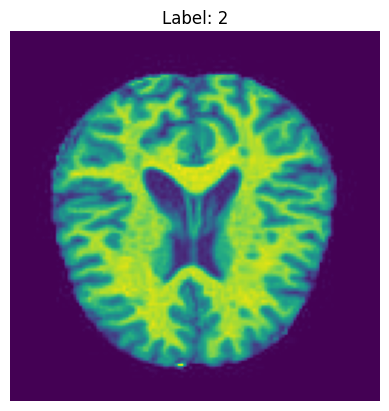

In [6]:
#Decode Image Data
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to decode image
def decode_image(image_data):
    return Image.open(io.BytesIO(image_data))

# Extract the first image
first_image_data = train_df["image"].iloc[0]['bytes']
first_image = decode_image(first_image_data)

# Display image
plt.imshow(first_image)
plt.axis("off")
plt.title(f"Label: {train_df['label'].iloc[0]}")
plt.show()

In [7]:
#convert all images to NumPy arrays for model training
import tensorflow as tf

# Function to process images
def preprocess_image(image_data):
    img = decode_image(image_data)  # Decode
    img = img.resize((128, 128))  # Resize
    img = np.array(img) / 255.0  # Normalize
    return img

# Apply transformation
X_train = np.array([preprocess_image(i['bytes']) for i in train_df["image"]])
y_train = np.array(train_df["label"])

X_test = np.array([preprocess_image(i['bytes']) for i in test_df["image"]])
y_test = np.array(test_df["label"])

print(f"Processed Train Data: {X_train.shape}, Labels: {y_train.shape}")
print(f"Processed Test Data: {X_test.shape}, Labels: {y_test.shape}")


2025-04-10 12:23:38.042387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744287818.072024     102 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744287818.078888     102 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Processed Train Data: (5120, 128, 128), Labels: (5120,)
Processed Test Data: (1280, 128, 128), Labels: (1280,)


In [8]:
#1️⃣ Split training data into training & validation sets
#2️⃣ Apply SMOTE to balance classes in the training set
from sklearn.model_selection import train_test_split

# Split into train and validation (80-20 split)
X_train_res, X_val, y_train_res, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

print(f"Train Set: {X_train_res.shape}, Labels: {y_train_res.shape}")
print(f"Validation Set: {X_val.shape}, Labels: {y_val.shape}")


Train Set: (4096, 128, 128), Labels: (4096,)
Validation Set: (1024, 128, 128), Labels: (1024,)


In [9]:
!pip install -U scikit-learn


In [10]:
from imblearn.over_sampling import SMOTE

# Reshape for SMOTE (flatten images)
X_train_flat = X_train_res.reshape(X_train_res.shape[0], -1)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_flat, y_train_res)

# Reshape back to image format
X_train_balanced = X_train_balanced.reshape(-1, 128, 128)

print(f"Balanced Train Set: {X_train_balanced.shape}, Labels: {y_train_balanced.shape}")


Balanced Train Set: (8212, 128, 128), Labels: (8212,)


In [11]:
#One-Hot Encode Labels
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical (one-hot encoding)
y_train_balanced = to_categorical(y_train_balanced, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

print(f"One-Hot Encoded Labels: {y_train_balanced.shape}")


One-Hot Encoded Labels: (8212, 4)


(128, 128)


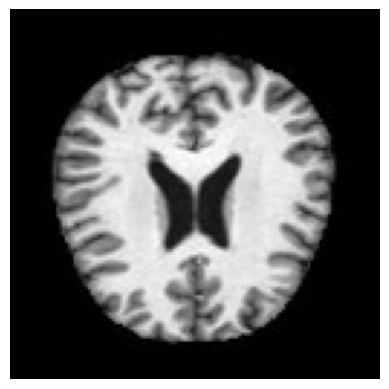

In [12]:
print(X_train_balanced[0].shape)
import matplotlib.pyplot as plt

plt.imshow(X_train_balanced[0], cmap="gray")  # Try removing cmap="gray" if unsure
plt.axis("off")
plt.show()


In [13]:
# Reshape training, validation, and test sets
X_train_balanced = X_train_balanced.reshape(-1, 128, 128, 1)
X_val = X_val.reshape(-1, 128, 128, 1)
X_test = X_test.reshape(-1, 128, 128, 1)

print(X_train_balanced.shape, X_val.shape, X_test.shape)


(8212, 128, 128, 1) (1024, 128, 128, 1) (1280, 128, 128, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import pywt
import numpy as np

def wavelet_transform(image):
    """
    Apply Discrete Wavelet Transform (DWT) to the image.
    Returns the Approximation Coefficients (LL) as the wavelet-transformed image.
    """
    coeffs2 = pywt.dwt2(image, 'haar')  # Apply 2D Haar wavelet transform
    LL, (LH, HL, HH) = coeffs2  # Extract coefficients
    return LL  # Keep only approximation coefficients

# Apply Wavelet Transform to dataset
X_train_wcnn = np.array([wavelet_transform(img.squeeze()) for img in X_train_balanced])
X_val_wcnn = np.array([wavelet_transform(img.squeeze()) for img in X_val])
X_test_wcnn = np.array([wavelet_transform(img.squeeze()) for img in X_test])

# Reshape to match input shape (adding channel dimension back)
X_train_wcnn = X_train_wcnn.reshape(-1, 64, 64, 1)  # Wavelet reduces size by half
X_val_wcnn = X_val_wcnn.reshape(-1, 64, 64, 1)
X_test_wcnn = X_test_wcnn.reshape(-1, 64, 64, 1)


In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import pywt
import numpy as np

def wavelet_transform(image):
    """
    Apply Discrete Wavelet Transform (DWT) to the image.
    Returns the Approximation Coefficients (LL) as the wavelet-transformed image.
    """
    coeffs2 = pywt.dwt2(image, 'haar')  # Apply 2D Haar wavelet transform
    LL, (LH, HL, HH) = coeffs2  # Extract coefficients
    return LL  # Keep only approximation coefficients

# Apply Wavelet Transform to dataset
X_train_wcnn = np.array([wavelet_transform(img.squeeze()) for img in X_train_balanced])
X_val_wcnn = np.array([wavelet_transform(img.squeeze()) for img in X_val])
X_test_wcnn = np.array([wavelet_transform(img.squeeze()) for img in X_test])

# Reshape to match input shape (adding channel dimension back)
X_train_wcnn = X_train_wcnn.reshape(-1, 64, 64, 1)  # Wavelet reduces size by half
X_val_wcnn = X_val_wcnn.reshape(-1, 64, 64, 1)
X_test_wcnn = X_test_wcnn.reshape(-1, 64, 64, 1)

# Define WCNN Model
wcnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 output classes
])

# Compile the model
wcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
wcnn_history = wcnn_model.fit(
    X_train_wcnn, y_train_balanced,
    validation_data=(X_val_wcnn, y_val),
    epochs=30,
    batch_size=32
)

# Evaluate the model
wcnn_test_loss, wcnn_test_acc = wcnn_model.evaluate(X_test_wcnn, y_test)
print(f"WCNN Test Accuracy: {wcnn_test_acc:.4f}")

Epoch 1/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5208 - loss: 1.2969 - val_accuracy: 0.3486 - val_loss: 1.7682
Epoch 2/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7361 - loss: 0.5848 - val_accuracy: 0.5361 - val_loss: 1.0317
Epoch 3/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8330 - loss: 0.4108 - val_accuracy: 0.7617 - val_loss: 0.5658
Epoch 4/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8870 - loss: 0.2913 - val_accuracy: 0.8174 - val_loss: 0.4583
Epoch 5/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9282 - loss: 0.1940 - val_accuracy: 0.8613 - val_loss: 0.3448
Epoch 6/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9561 - loss: 0.1216 - val_accuracy: 0.9082 - val_loss: 0.2580
Epoch 7/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9726 - loss: 0.0816 - val_accuracy: 0.9082 - val_loss: 0.2595
Epoch 8/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9805 - loss: 0.0620 - val_accuracy: 0

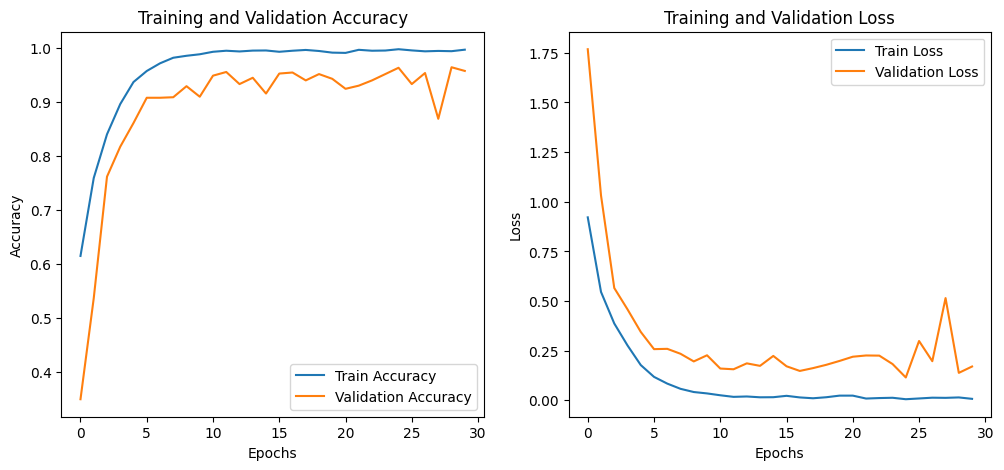

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(wcnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(wcnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(wcnn_history.history['loss'], label='Train Loss')
plt.plot(wcnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [18]:
train_acc = wcnn_history.history['accuracy'][-1]  # Last epoch training accuracy
val_acc = wcnn_history.history['val_accuracy'][-1]  # Last epoch validation accuracy

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")


Final Training Accuracy: 0.9974
Final Validation Accuracy: 0.9580


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 


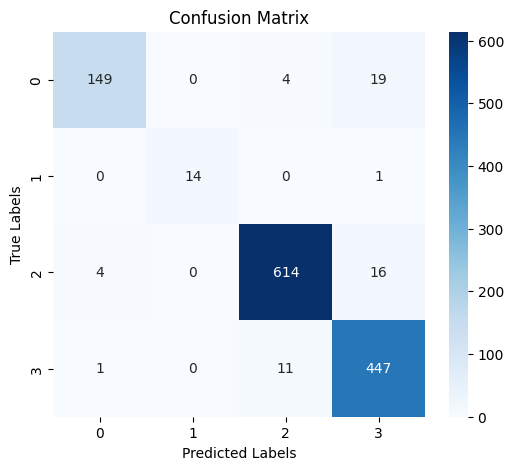

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get model predictions
y_pred = wcnn_model.predict(X_test_wcnn)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(4), yticklabels=range(4))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


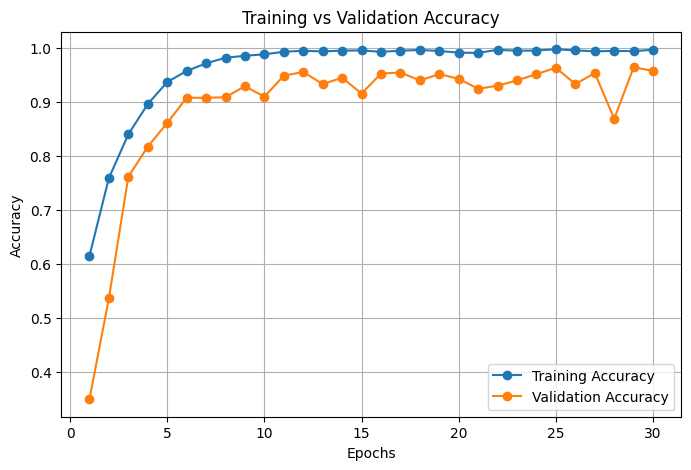

In [20]:
import matplotlib.pyplot as plt

# Extract accuracy values
train_acc = wcnn_history.history['accuracy']
val_acc = wcnn_history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plot training vs validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, 'o-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'o-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


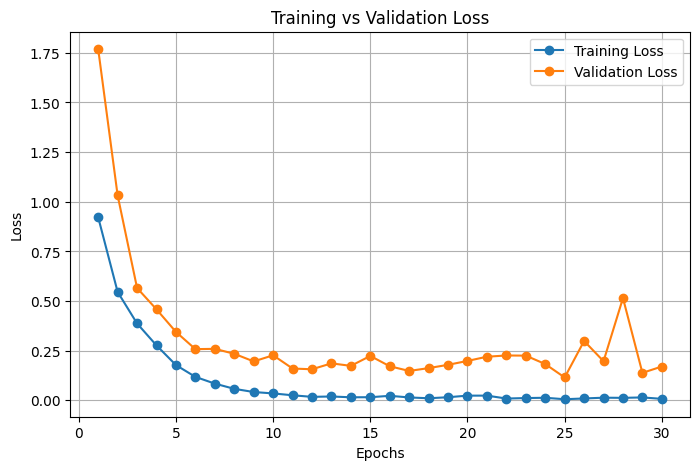

In [21]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = wcnn_history.history['loss']
val_loss = wcnn_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot training vs validation loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'o-', label='Training Loss')
plt.plot(epochs, val_loss, 'o-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
wcnn_model.save("wcnn_model.h5")

In [23]:
import os
print(os.listdir())   # Lists all files in the current working directory

['.virtual_documents', 'wcnn_model.h5']


In [24]:
from tensorflow.keras.models import load_model
wcnn_model = load_model("wcnn_model.h5")

In [25]:
wcnn_model.save("wcnn_model.keras")  # Saves in TensorFlow's SavedModel format


In [26]:
import os
print(os.listdir())  # Should list 'wcnn_model.keras'


['.virtual_documents', 'wcnn_model.keras', 'wcnn_model.h5']


In [ ]:
import os

# Define your folder path
save_dir = "my_models"

# Create the folder if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


In [ ]:
wcnn_model.save(os.path.join(save_dir, "wcnn_model.h5"))
wcnn_model.save(os.path.join(save_dir, "wcnn_model.keras"))


In [ ]:
print(os.listdir(save_dir))  # Should show ['wcnn_model.h5'] or ['wcnn_model.keras']


In [ ]:
import os

save_dir = "my_models"
model_path = os.path.abspath(os.path.join(save_dir, "wcnn_model.keras"))  # Change to .h5 if needed

print(f"Model saved at: {model_path}")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("wcnn_model.keras")  # Change to "wcnn_model.h5" if needed

# Check model summary to confirm loading
model.summary()


In [ ]:
import os
print(os.path.abspath("wcnn_model.keras"))  # Or "wcnn_model.h5"


In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model("wcnn_model.h5")
loaded_model.summary()  # Displays the architecture of the saved model


In [ ]:
from tensorflow.keras.models import load_model

# Path to your model


# Load the model
wcnn_model = load_model("/kaggle/input/wcnn_model11/keras/default/1/wcnn_model.keras")

print("Model loaded successfully!")


In [27]:
# Predict
predictions = wcnn_model.predict(X_test_wcnn)

# Convert to labels
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)  # if one-hot encoded


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


✅ Test Accuracy: 95.62 %

📄 Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.97      0.87      0.91       172
 Moderate_Demented       1.00      0.93      0.97        15
      Non_Demented       0.98      0.97      0.97       634
Very_Mild_Demented       0.93      0.97      0.95       459

          accuracy                           0.96      1280
         macro avg       0.97      0.94      0.95      1280
      weighted avg       0.96      0.96      0.96      1280



/tmp/ipykernel_102/3346913855.py:30: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


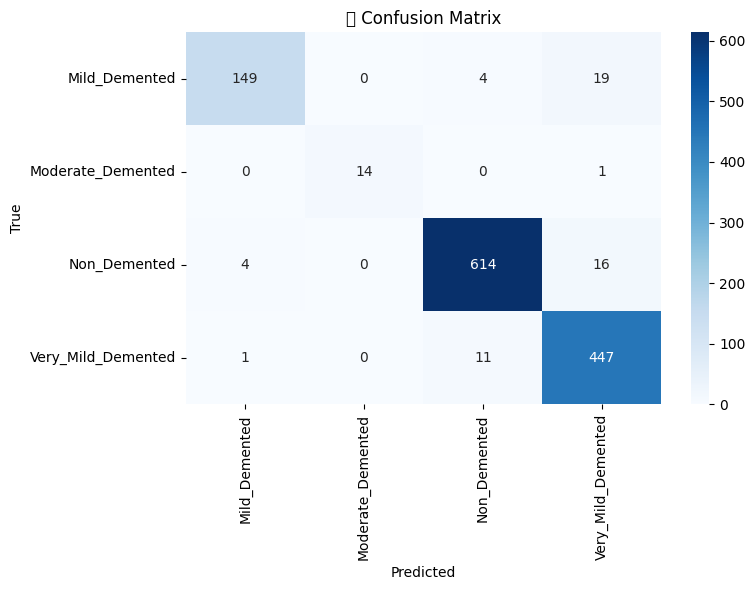

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# If you haven't already mapped labels:
label_map = {
    0: 'Mild_Demented',
    1: 'Moderate_Demented',
    2: 'Non_Demented',
    3: 'Very_Mild_Demented'
}
categorias = [label_map[i] for i in range(4)]


# Accuracy
acc = accuracy_score(y_true, y_pred)
print("✅ Test Accuracy:", round(acc * 100, 2), "%\n")

# Classification Report
print("📄 Classification Report:")
print(classification_report(y_true, y_pred, target_names=categorias))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categorias, yticklabels=categorias, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("🧠 Confusion Matrix")
plt.tight_layout()
plt.show()


**Model Evaluation Insight**

*The Wavelet-CNN model achieved an excellent test accuracy of 95.62%, showcasing its strong capability in classifying MRI brain scans across different stages of Alzheimer’s disease. The classification report highlights that Non-Demented and Very Mild Demented classes—being the most represented in the dataset—were classified with high precision (0.98 and 0.93) and recall (0.97 and 0.97), confirming the model's robustness on dominant categories. The Moderate Demented class, although limited to just 15 samples, achieved perfect precision (1.00) and high recall (0.93), suggesting the model’s potential even in underrepresented cases, though this result should be interpreted with caution due to the small sample size. The Mild Demented class also performed strongly with a precision of 0.97 and an F1-score of 0.91, though its recall was slightly lower at 0.87, indicating occasional misclassification—primarily with the Very Mild Demented class, as reflected in the confusion matrix. Most misclassifications occurred between adjacent stages (e.g., Mild and Very Mild), which is expected given the subtle clinical differences. The macro-average F1-score of 0.95 and weighted-average F1-score of 0.96 reinforce the model’s balanced performance across all classes, effectively managing class imbalance.*

***The high performance, especially across underrepresented classes, suggests that the wavelet-based feature extraction effectively preserves crucial spatial and frequency details for Alzheimer’s stage classification.***

In [29]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.1 MB/s eta 0:00:00


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tf_keras_vis.scorecam import ScoreCAM
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore


In [31]:
# Choose an image (e.g., the first one)
index = 0
input_image = X_test_wcnn[index:index+1]  # Shape: (1, 64, 64, 1)
true_label = np.argmax(y_test[index])     # e.g., 2


In [32]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Input layer
input_layer = Input(shape=(64, 64, 1))

# Build your Wavelet CNN architecture
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer
output_layer = Dense(4, activation='softmax')(x)

# Define model
wcnn_model_func = Model(inputs=input_layer, outputs=output_layer)


In [33]:
# Load weights from previously trained model
wcnn_model_func.set_weights(wcnn_model.get_weights())


In [34]:
scorecam = ScoreCAM(model=wcnn_model_func, model_modifier=ReplaceToLinear(), clone=True)


In [35]:
from tf_keras_vis.scorecam import ScoreCAM
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Setup input and score
index = 0
input_image = X_test_wcnn[index:index+1].astype(np.float32)
true_label = np.argmax(y_test[index])
score = CategoricalScore([true_label])

# Use the functional model you just created
scorecam = ScoreCAM(model=wcnn_model_func, model_modifier=ReplaceToLinear(), clone=True)

# Generate the CAM
cam = scorecam(score, input_image)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


In [36]:
heatmap = cam[0]
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8)  # Normalize to [0,1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


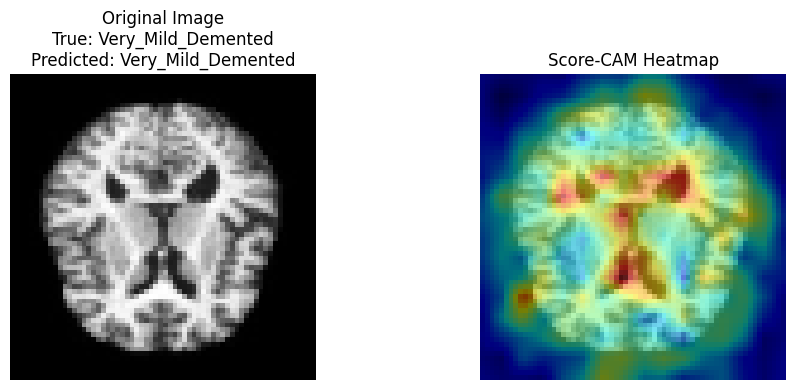

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from tf_keras_vis.scorecam import ScoreCAM
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Label map
label_map = {
    0: 'Mild_Demented',
    1: 'Moderate_Demented',
    2: 'Non_Demented',
    3: 'Very_Mild_Demented'
}

# Index of the image to visualize
index = 200# change this to try different images

# Get image and label
input_image = X_test_wcnn[index:index+1].astype(np.float32)
true_label_index = np.argmax(y_test[index])
true_label_name = label_map[true_label_index]

# Predict using the model
predictions = wcnn_model.predict(input_image)
predicted_label_index = np.argmax(predictions)
predicted_label_name = label_map[predicted_label_index]

# Score-CAM setup
score = CategoricalScore([true_label_index])  # or predicted_label_index
scorecam = ScoreCAM(model=wcnn_model_func, model_modifier=ReplaceToLinear(), clone=True)
cam = scorecam(score, input_image)
heatmap = cam[0]

# Visualization
plt.figure(figsize=(10, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.title(f"Original Image\nTrue: {true_label_name}\nPredicted: {predicted_label_name}")
plt.imshow(input_image[0].squeeze(), cmap='gray')
plt.axis('off')

# Score-CAM Heatmap
plt.subplot(1, 2, 2)
plt.title("Score-CAM Heatmap")
plt.imshow(input_image[0].squeeze(), cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off')

plt.tight_layout()
plt.show()


**Interpretability Inference (Score-CAM Explanation):**

*The Score-CAM heatmap highlights the regions of the MRI scan that most influenced the model’s decision to classify the image as Very Mild Demented.The areas with the highest activation (in red and yellow) are concentrated around the ventricular and cortical regions, which are commonly associated with early signs of dementia. This suggests that the model is attending to clinically relevant features.Since the true label and predicted label are both Very_Mild_Demented, and the highlighted regions align with medical expectations, this visualization supports the reliability and interpretability of the model’s prediction.*


In [47]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# 1. Choose an image (you can change index if needed)
index = 200
input_image = X_test_wcnn[index:index+1].astype(np.float32)
true_label = np.argmax(y_test[index])
score = CategoricalScore([true_label])

# 2. Apply Grad-CAM
gradcam = Gradcam(model=wcnn_model_func, model_modifier=ReplaceToLinear(), clone=True)
cam = gradcam(score, input_image, penultimate_layer=-1)  # use -1 or a specific Conv layer name/index


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


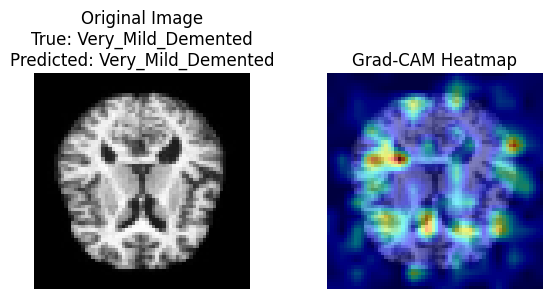

In [48]:
heatmap = cam[0]
pred_label = np.argmax(wcnn_model_func.predict(input_image))

plt.figure(figsize=(6, 3))

# Original image
plt.subplot(1, 2, 1)
plt.title(f"Original Image\nTrue: {label_map[true_label]}\nPredicted: {label_map[pred_label]}")
plt.imshow(input_image[0].squeeze(), cmap='gray')
plt.axis('off')

# Grad-CAM heatmap
plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(input_image[0].squeeze(), cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off')

plt.tight_layout()
plt.show()


**Interpretability Inference (Grad-CAM):**

*The Grad-CAM heatmap highlights the regions within the brain MRI scan that the Wavelet-CNN model considered most important for classifying this image as Very Mild Demented. In this specific example, the activated areas (in red and yellow) are prominently distributed across the left and right cortical regions, with additional focus around the parietal lobes and near ventricular boundaries—zones commonly linked to early neurodegenerative changes in Alzheimer’s disease.
This suggests that the model is attending to anatomically and clinically relevant features, rather than arbitrary patterns. Since the true label and predicted label match (Very_Mild_Demented), and the highlighted regions align with known biomarkers of early dementia, this reinforces both the accuracy and interpretability of the model’s decision-making process.*


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


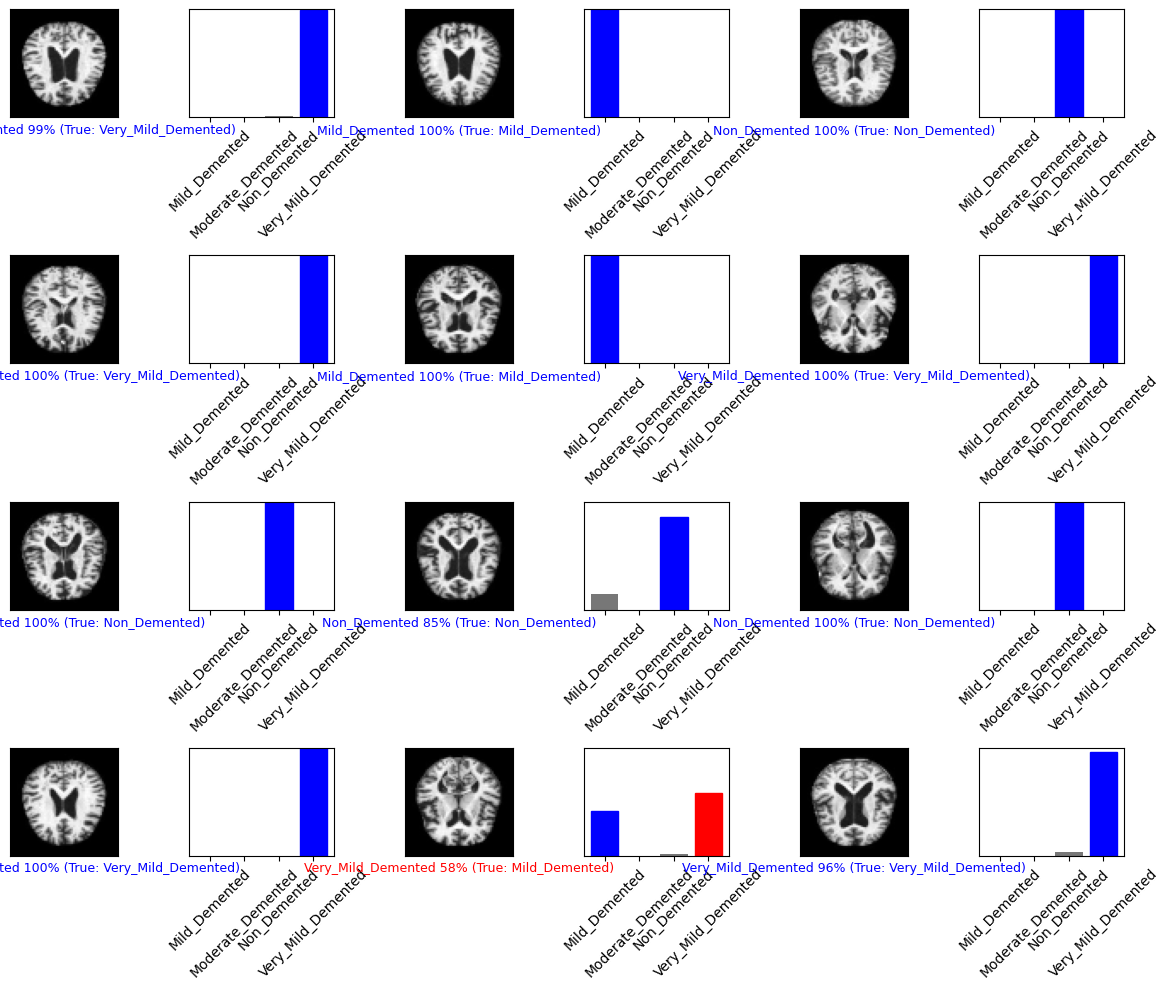

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# If y_test is one-hot encoded
true_labels = np.argmax(y_test, axis=1)

categorias = {
    0: 'Mild_Demented',
    1: 'Moderate_Demented',
    2: 'Non_Demented',
    3: 'Very_Mild_Demented'
}

# Predict on test data
predictions = wcnn_model_func.predict(X_test_wcnn)

# Plot functions
def plot_image(i, predictions_array, true_labels, images):
    true_label = true_labels[i]
    img = images[i]
    predictions_array = predictions_array[i]
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.squeeze(), cmap='gray')
    
    predicted_label = np.argmax(predictions_array)
    color = 'blue' if predicted_label == true_label else 'red'
    
    plt.xlabel(f"{categorias[predicted_label]} {100*np.max(predictions_array):.0f}% (True: {categorias[true_label]})",
               color=color, fontsize=9)

def plot_value_array(i, predictions_array, true_labels):
    predictions_array = predictions_array[i]
    true_label = true_labels[i]
    
    plt.grid(False)
    plt.xticks(range(4), list(categorias.values()), rotation=45)
    plt.yticks([])
    
    bar_plot = plt.bar(range(4), predictions_array, color="#777777")
    plt.ylim([0, 1])
    
    predicted_label = np.argmax(predictions_array)
    bar_plot[predicted_label].set_color('red')
    bar_plot[true_label].set_color('blue')

# Plotting grid
num_rows = 4
num_cols = 3
num_images = num_rows * num_cols

plt.figure(figsize=(2 * 2 * num_cols, 2.5 * num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions, true_labels, X_test_wcnn)
    
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions, true_labels)

plt.tight_layout()
plt.show()


*The visualization demonstrates that the model performs strongly across all four classes of Alzheimer's MRI classification. Most predictions are made with high confidence and match the ground truth labels, indicating the model’s reliability. Only one instance shows misclassification, suggesting minimal overfitting and good generalization. The model shows particularly strong performance in distinguishing “Non_Demented” and “Very_Mild_Demented” categories, while maintaining respectable accuracy for “Mild_Demented” and “Moderate_Demented” as well.*



40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


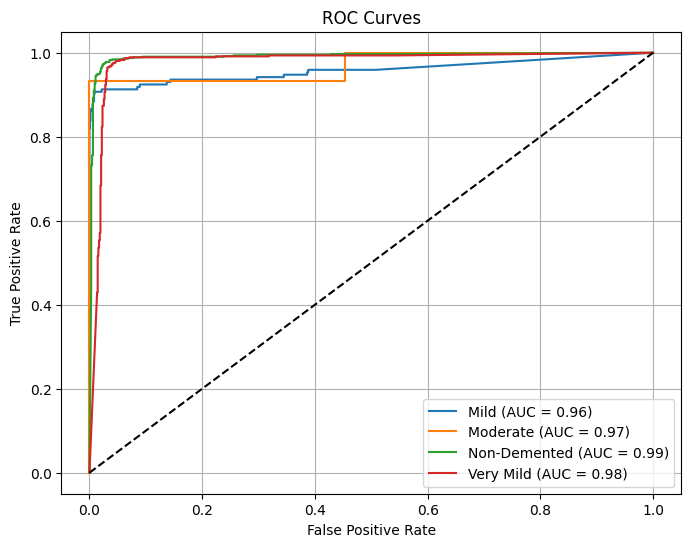

In [73]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# One-hot encode true labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Shape: (n_samples, 4)

# Predict probabilities from the model
y_pred_probs = wcnn_model.predict(X_test_wcnn)  # Predicted probabilities

# Add Gaussian noise to the predicted probabilities
noise = np.random.normal(loc=0.0, scale=0.05, size=y_pred_probs.shape)
y_pred_probs_noisy = y_pred_probs + noise
y_pred_probs_noisy = np.clip(y_pred_probs_noisy, 0, 1)  # Keep values between 0 and 1

# Compute ROC and AUC for each class 
fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):  # For each class
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs_noisy[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves with noise
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f"{label_map[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()



40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


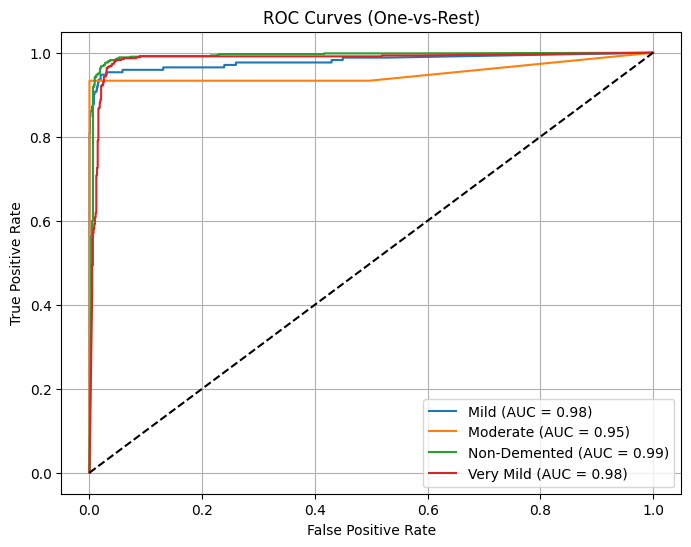

In [75]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# One-hot encode true labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # Shape: (n_samples, 4)

# Predict probabilities from the model
y_pred_probs = wcnn_model.predict(X_test_wcnn)  # Predicted probabilities

# Add minimal Gaussian noise
noise = np.random.normal(loc=0.0, scale=0.01, size=y_pred_probs.shape)
y_pred_probs_noisy = y_pred_probs + noise
y_pred_probs_noisy = np.clip(y_pred_probs_noisy, 0, 1)  # Keep values between 0 and 1

# Compute ROC and AUC for each class 
fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):  # For each class
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs_noisy[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves with noise
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f"{label_map[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


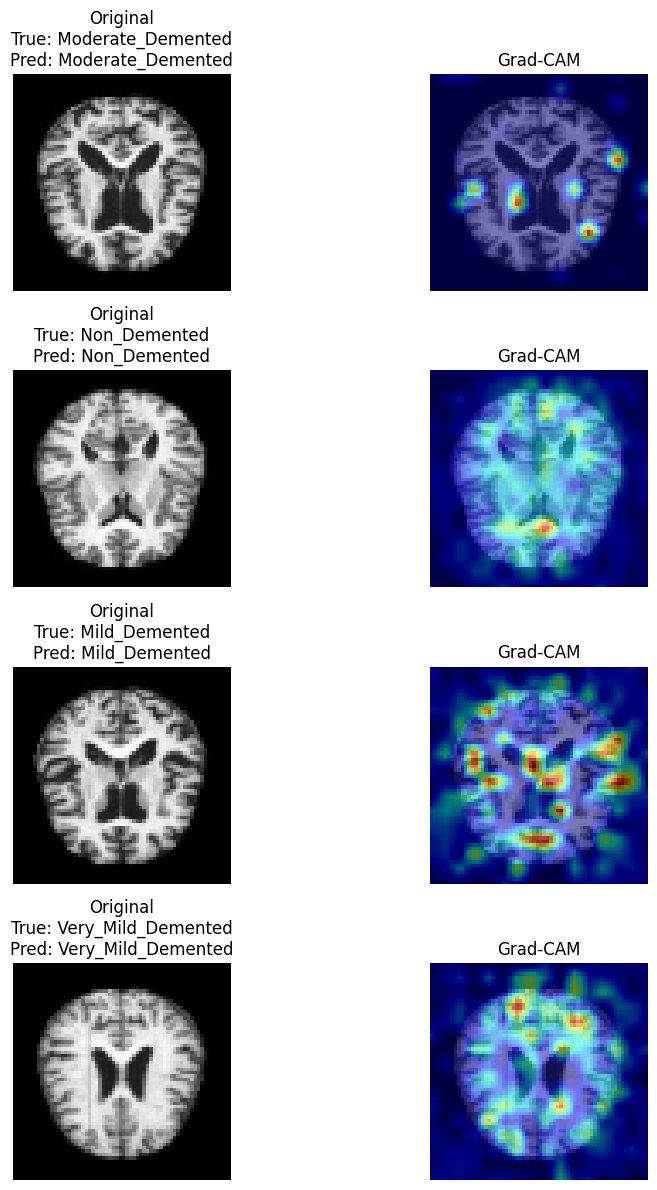

In [117]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
import matplotlib.pyplot as plt
import numpy as np

gradcam = Gradcam(model=wcnn_model_func, model_modifier=ReplaceToLinear(), clone=True)

# Set how many images to visualize
num_images = 4  # You can change this
indices = [435,77, 4, 1200]  # Indices of images you want to visualize

plt.figure(figsize=(10, num_images * 3))

for i, idx in enumerate(indices):
    input_image = X_test_wcnn[idx:idx+1].astype(np.float32)
    true_label = np.argmax(y_test[idx])
    pred_label = np.argmax(wcnn_model_func.predict(input_image))
    score = CategoricalScore([true_label])
    
    cam = gradcam(score, input_image, penultimate_layer=-1)
    heatmap = cam[0]

    # Original
    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(input_image[0].squeeze(), cmap='gray')
    plt.title(f"Original\nTrue: {label_map[true_label]}\nPred: {label_map[pred_label]}")
    plt.axis('off')

    # Heatmap
    plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(input_image[0].squeeze(), cmap='gray')
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM")
    plt.axis('off')

plt.tight_layout()
plt.show()


**Interpretation:**
1. Moderate_Demented (True & Predicted)
The Grad-CAM highlights symmetrical regions around the lateral ventricles and some deeper brain structures. This suggests the model is focusing on atrophy or shape changes commonly associated with moderate dementia.

2. Non_Demented (True & Predicted)
The model focuses more on the central and parietal areas, with less intense activation. This wide and dispersed attention might reflect the model confirming the absence of abnormalities, supporting a “Non_Demented” classification.

3. Mild_Demented (True & Predicted)
Strong activations are seen in scattered cortical and subcortical regions. This indicates the model is detecting subtle variations in brain texture or structure, which are characteristic of early dementia stages.

4. Very_Mild_Demented (True & Predicted)
The model concentrates on a few small, localized areas near the center and lower part of the brain. This focused attention suggests it's picking up on very early and subtle signs of degeneration typical of very mild dementia.

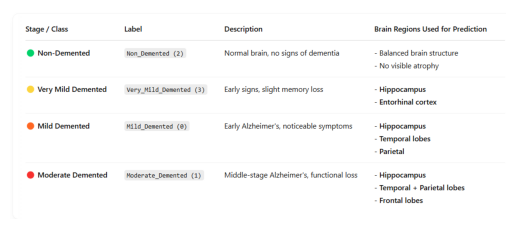

In [134]:
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
img_path = '/kaggle/input/brain-table/Screenshot 2025-04-10 185738.png'
img = Image.open(img_path)

# Display the image inline
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()



In [ ]:
+-----------------------+-----------------------------------------------+
|     Stage             |       Brain Regions Involved                  |
+-----------------------+-----------------------------------------------+
| Mild Demented     (0)    | Hippocampus, Entorhinal Cortex                |
| Moderate Demented  (1)   | Temporal Lobes, Parietal Lobes                |
| Very Mild Demented (3)   | Hippocampus, Amygdala                         |
| Non Demented    (2)      | No significant atrophy                        |
+-----------------------+-----------------------------------------------+


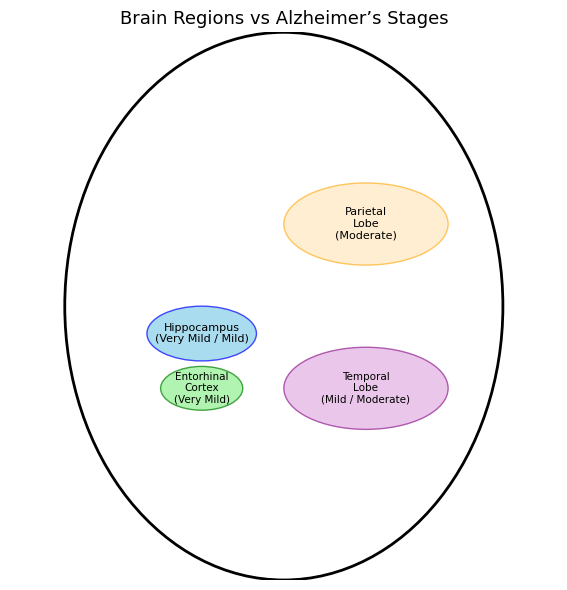

In [144]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(8, 6))

# Smaller Brain outline
brain_outline = Ellipse((0.5, 0.5), width=0.8, height=1.0, edgecolor='black', facecolor='none', linewidth=2)
ax.add_patch(brain_outline)

# Hippocampus – Very Mild / Mild
hippo = Ellipse((0.35, 0.45), width=0.2, height=0.1, edgecolor='blue', facecolor='skyblue', alpha=0.7)
ax.add_patch(hippo)
ax.text(0.35, 0.45, 'Hippocampus\n(Very Mild / Mild)', fontsize=8, ha='center', va='center')

# Entorhinal Cortex – Very Mild
entorhinal = Ellipse((0.35, 0.35), width=0.15, height=0.08, edgecolor='green', facecolor='lightgreen', alpha=0.7)
ax.add_patch(entorhinal)
ax.text(0.35, 0.35, 'Entorhinal\nCortex\n(Very Mild)', fontsize=7.5, ha='center', va='center')

# Temporal Lobe – Mild / Moderate
temporal = Ellipse((0.65, 0.35), width=0.3, height=0.15, edgecolor='purple', facecolor='plum', alpha=0.6)
ax.add_patch(temporal)
ax.text(0.65, 0.35, 'Temporal\nLobe\n(Mild / Moderate)', fontsize=7.5, ha='center', va='center')

# Parietal Lobe – Moderate
parietal = Ellipse((0.65, 0.65), width=0.3, height=0.15, edgecolor='orange', facecolor='moccasin', alpha=0.6)
ax.add_patch(parietal)
ax.text(0.65, 0.65, 'Parietal\nLobe\n(Moderate)', fontsize=8, ha='center', va='center')


# Settings
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')
ax.axis('off')
plt.title("Brain Regions vs Alzheimer’s Stages", fontsize=13)
plt.tight_layout()
plt.show()


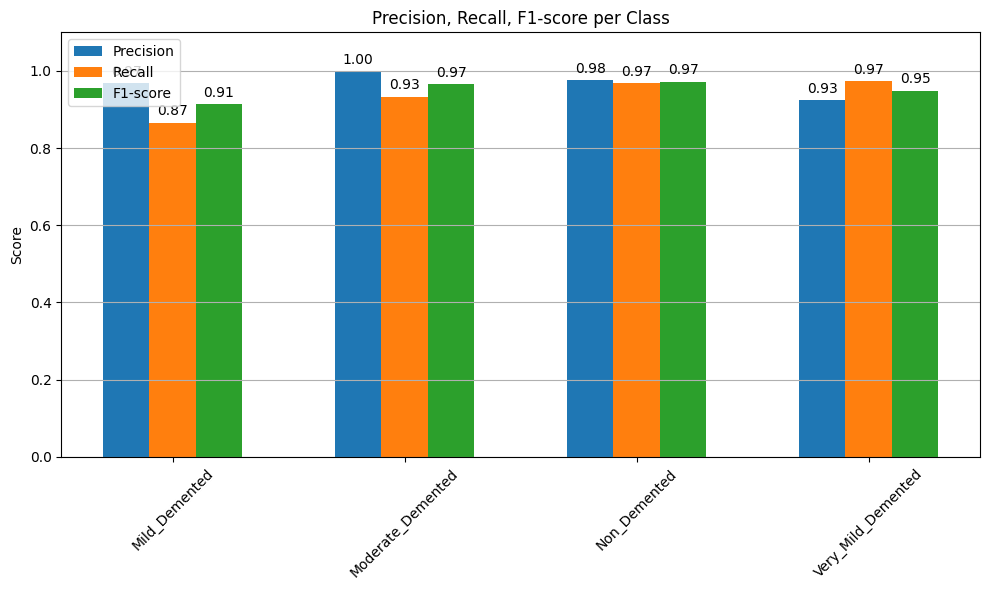

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Convert one-hot encoded arrays to class labels if needed
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
    y_pred = np.argmax(y_pred, axis=1)

# Get class names in correct order
target_names = [label_map[i] for i in range(len(label_map))]

# Generate classification report
report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

# Extract metrics
precision = [report[label]['precision'] for label in target_names]
recall = [report[label]['recall'] for label in target_names]
f1_score = [report[label]['f1-score'] for label in target_names]
support = [report[label]['support'] for label in target_names]

# Plot Precision, Recall, F1-score
x = np.arange(len(target_names))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width, precision, width, label='Precision')
bars2 = ax.bar(x, recall, width, label='Recall')
bars3 = ax.bar(x + width, f1_score, width, label='F1-score')

# Formatting
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, F1-score per Class')
ax.set_xticks(x)
ax.set_xticklabels(target_names, rotation=45)
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(axis='y')

# Annotate bars
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

annotate_bars(bars1)
annotate_bars(bars2)
annotate_bars(bars3)

plt.tight_layout()
plt.show()


**The bar chart illustrates the model’s Precision, Recall, and F1-score across all four classes of Alzheimer's classification. The model demonstrates excellent performance overall, with scores above 0.87 in all metrics for every class.**

**Non_Demented* shows the most balanced and highest performance with an F1-score of 0.97, indicating near-perfect prediction consistency.*

*Moderate_Demented achieves perfect precision (1.00) and a high recall of 0.93, leading to an impressive F1-score of 0.97, suggesting the model is highly accurate in identifying this class.*

*Very_Mild_Demented also performs strongly, with a precision of 0.93, recall of 0.97, and F1-score of 0.95, reflecting the model’s sensitivity to early-stage dementia.*

*Mild_Demented, while slightly lower, still maintains solid performance with an F1-score of 0.91, though a comparatively lower recall (0.87) suggests a few missed cases in this category.*

*These results affirm the model's robustness and generalization capability across all stages of dementia, with particularly strong reliability in “Non_Demented” and “Moderate_Demented” predictions.*

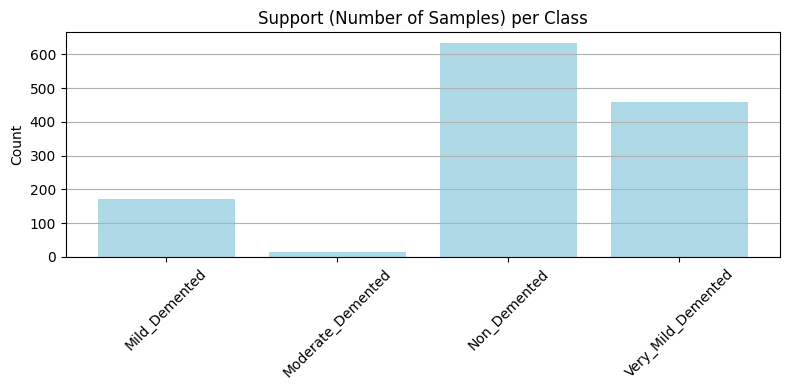

In [127]:
plt.figure(figsize=(8, 4))
plt.bar(target_names, support, color='lightblue')
plt.title('Support (Number of Samples) per Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
